In [51]:
# %% Import modules
import torch
import einops

from transformer_lens import HookedTransformer


import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# Global settings and variables
sns.set()
torch.set_grad_enabled(False)
device = "cpu"

IPSUM = "Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum."
# IPSUM = ""

In [53]:
#%% Setup model & load data
model = HookedTransformer.from_pretrained('gelu-4l')
model.cfg.use_attn_result = True
model.to(device)

prompts_t = get_prompts_t()

Loaded pretrained model gelu-4l into HookedTransformer
Moving model to device:  cpu
Loading 80 prompts from c4-tokenized-2b...


100%|██████████| 80/80 [00:02<00:00, 34.96it/s]


Loading 20 prompts from code-tokenized...


100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


In [54]:
examples = [
    {
        "text": 4 * IPSUM + " It's in the cupboard, either on the top or the",
        "correct": " bottom",
        "incorrect": " top",
    },
    {
        "text": 5 * IPSUM + " I went to university at Michigan",
        "correct": " State",
        "incorrect": " University",
    },
    {
        "text": IPSUM + " class MyClass:\n\tdef",
        "correct": " __",
        "incorrect": " on",
    },
    {
        "text": 6 * IPSUM + "The church I go to is the Seventh-day Adventist",
        "correct": " Church",
        "incorrect": " Advent",
    }
]

In [55]:
def get_results(model, example):
    token_ids = model.to_tokens(example["text"])
    correct_token_id = model.to_single_token(example["correct"])
    incorrect_token_id = model.to_single_token(example["incorrect"])
    logit_diff_direction = (
        model.W_U[:, correct_token_id] - model.W_U[:, incorrect_token_id]
    )  # (d_model,)

    _, cache = model.run_with_cache(
        token_ids,
        names_filter=lambda name: (
            name == "blocks.0.attn.hook_result"
            or name == "blocks.2.attn.hook_result"
            or name == "ln_final.hook_scale"
            or name == "ln_final.hook_normalized"
        ),
    )

    
    # (resid, batch, pos, d_model)
    L0H2 = cache["blocks.0.attn.hook_result"][:, :, 2, :]  # (batch, pos, d_model)
    L2HX = einops.reduce(
        cache["blocks.2.attn.hook_result"],
        "batch pos head d_model -> batch pos d_model",
        "sum",
    )
    scale = cache["ln_final.hook_scale"]

    apply_ln = lambda x: (x - x.mean(dim=-1, keepdim=True)) / scale
    L0H2_ln = apply_ln(L0H2)
    L2HX_ln = apply_ln(L2HX)

    return (
        L0H2_ln[0, -1, :] @ logit_diff_direction,
        L2HX_ln[0, -1, :] @ logit_diff_direction,
    )

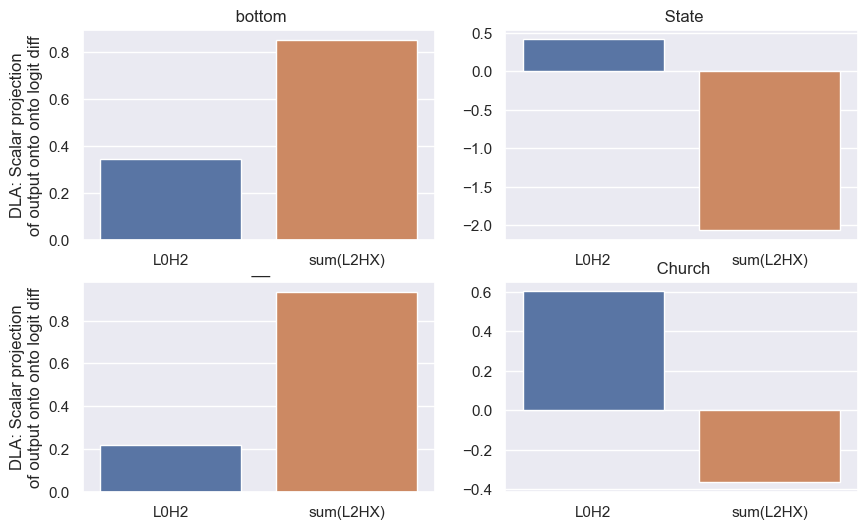

In [56]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

for i in range(len(examples)):
    head_names = ["L0H2", "sum(L2HX)"]
    dlas = get_results(model, examples[i])
    dlas = [dla.item() for dla in dlas]

    row = i // 2
    col = i % 2
    sns.barplot(x=head_names, y=dlas, ax=ax[row][col])
    ax[row][col].set_title(examples[i]["correct"])
    if col == 0:
        ax[row][col].set_ylabel("DLA: Scalar projection\nof output onto onto logit diff")